<a href="https://colab.research.google.com/github/KamithaVihanga/machine_unlearning/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Training Loss: 2.062, Validation Loss: 1.440
Epoch 2, Training Loss: 1.814, Validation Loss: 1.371
Epoch 3, Training Loss: 1.718, Validation Loss: 1.238
Epoch 4, Training Loss: 1.662, Validation Loss: 1.128
Epoch 5, Training Loss: 1.597, Validation Loss: 1.020
Epoch 6, Training Loss: 1.572, Validation Loss: 0.993
Epoch 7, Training Loss: 1.548, Validation Loss: 0.913
Epoch 8, Training Loss: 1.507, Validation Loss: 0.869
Epoch 9, Training Loss: 1.483, Validation Loss: 0.851
Epoch 10, Training Loss: 1.491, Validation Loss: 0.875
Epoch 11, Training Loss: 1.444, Validation Loss: 0.796
Epoch 12, Training Loss: 1.425, Validation Loss: 0.807
Epoch 13, Training Loss: 1.419, Validation Loss: 0.738
Epoch 14, Training Loss: 1.419, Validation Loss: 0.830
Epoch 15, Train

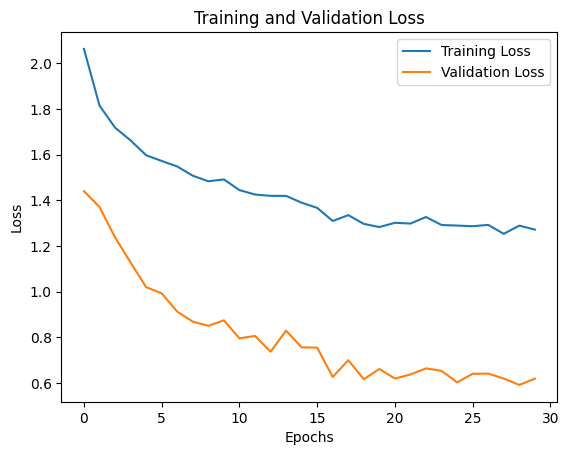

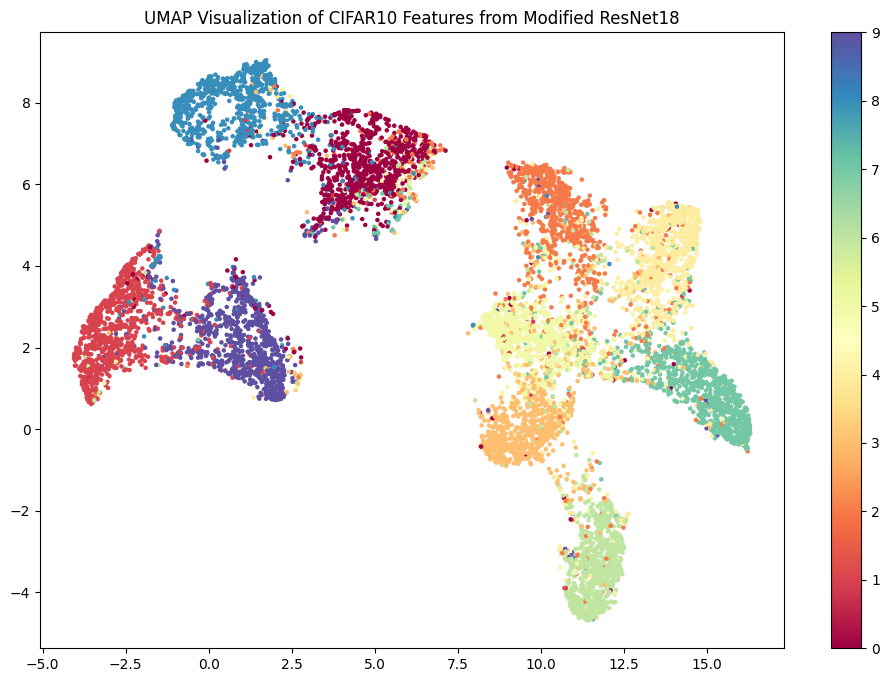

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Precision of plane : 0.76
Precision of car : 0.85
Precision of bird : 0.80
Precision of cat : 0.91
Precision of deer : 0.88
Precision of dog : 0.72
Precision of frog : 0.85
Precision of horse : 0.80
Precision of ship : 0.91
Precision of truck : 0.86
Overall Precision: 0.83


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


F1 Score of plane : 0.82
F1 Score of car : 0.89
F1 Score of bird : 0.77
F1 Score of cat : 0.78
F1 Score of deer : 0.79
F1 Score of dog : 0.75
F1 Score of frog : 0.86
F1 Score of horse : 0.85
F1 Score of ship : 0.89
F1 Score of truck : 0.86
Overall F1 Score: 0.83


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy for class: plane is 88.9 %
Accuracy for class: car   is 92.9 %
Accuracy for class: bird  is 74.3 %
Accuracy for class: cat   is 70.0 %
Accuracy for class: deer  is 71.7 %
Accuracy for class: dog   is 80.2 %
Accuracy for class: frog  is 86.9 %
Accuracy for class: horse is 89.6 %
Accuracy for class: ship  is 88.2 %
Accuracy for class: truck is 86.4 %


In [2]:
!pip install torch torchvision numba umap-learn scikit-learn
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score
from PIL import Image
import umap.umap_ as umap
from sklearn.metrics import f1_score
from google.colab import drive
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomAffine, ColorJitter
drive.mount('/content/drive')

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Modified ResNet18 with additional dropout layers
class ModifiedResNet18(nn.Module):
    def __init__(self):
        super(ModifiedResNet18, self).__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.dropout(x)  # Dropout after layer3
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Dropout before final layer
        x = self.resnet.fc(x)

        return x

# Custom CIFAR10 Dataset with specific augmentations for 'cat' and 'dog'
class CustomCIFAR10(CIFAR10):
    def __init__(self, *args, **kwargs):
        super(CustomCIFAR10, self).__init__(*args, **kwargs)
        self.class_to_idx = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

    def __getitem__(self, index):
        img, label = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        # Specific augmentations for 'cat' and 'dog'
        if label == self.class_to_idx['cat'] or label == self.class_to_idx['dog']:
            img = transforms.ColorJitter(brightness=0.2, contrast=0.2)(img)
            img = transforms.RandomRotation(15)(img)
        else:
            # Additional augmentation for other classes
            img = transforms.RandomVerticalFlip()(img)
            img = transforms.RandomResizedCrop(32, scale=(0.8, 1.0))(img)

        img = self.transform(img) if self.transform else img
        return img, label
    def __getitem__(self, index):
        img, label = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        # Apply specific augmentations for 'cat' class
        if label == self.class_to_idx['cat']:
            img = transforms.ColorJitter(brightness=0.2, contrast=0.2)(img)
            img = transforms.RandomRotation(15)(img)

        img = self.transform(img) if self.transform else img
        return img, label

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Data Augmentation transformations for the training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

BATCH_SIZE = 64

# CustomCIFAR10 dataset
trainset = CustomCIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

valset = CustomCIFAR10(root='./data', train=False, download=True, transform=val_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Model setup
net = ModifiedResNet18().to(device)

# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)

# Adjusted class weights for loss function
class_weights = torch.tensor([1.2 if i == 3 else 1.0 for i in range(10)], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training loop
train_losses = []
val_losses = []

for epoch in range(30):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Apply mixup
        mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)

        optimizer.zero_grad()
        outputs = net(mixed_inputs)
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(valloader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}')

print('Finished Training')
model_path = '/content/drive/My Drive/ml/trained_model.pth'
torch.save(net.state_dict(), model_path)

# Plotting the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# UMAP feature extraction and visualization
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(ResNet18FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x
feature_extractor = ResNet18FeatureExtractor(net).eval().to(device)
features = []
labels_list = []
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = feature_extractor(images)
        features.extend(outputs.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

reducer = umap.UMAP()
embedding = reducer.fit_transform(np.array(features))
plt.figure(figsize=(12, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_list, cmap='Spectral', s=5)
plt.colorbar()
plt.title('UMAP Visualization of CIFAR10 Features from Modified ResNet18')
plt.show()

# Precision calculation
all_labels = []
all_predictions = []
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
precisions = [precision_score(all_labels, all_predictions, labels=[i], average='micro') for i in range(len(classes))]
for i, cls in enumerate(classes):
    print(f'Precision of {cls} : {precisions[i]:.2f}')

overall_precision = precision_score(all_labels, all_predictions, average='micro')
print(f'Overall Precision: {overall_precision:.2f}')

# F1 score calculation
all_labels = []
all_predictions = []
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
f1_scores = [f1_score(all_labels, all_predictions, labels=[i], average='micro') for i in range(len(classes))]

for i, cls in enumerate(classes):
    print(f'F1 Score of {cls} : {f1_scores[i]:.2f}')

overall_f1 = f1_score(all_labels, all_predictions, average='micro')
print(f'Overall F1 Score: {overall_f1:.2f}')

# Initialize counters
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# No gradient needed
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Step2 -2

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Training Loss: 1.353, Validation Loss: 0.716
Epoch 2, Training Loss: 1.336, Validation Loss: 0.721
Epoch 3, Training Loss: 1.326, Validation Loss: 0.702
Epoch 4, Training Loss: 1.316, Validation Loss: 0.658
Epoch 5, Training Loss: 1.305, Validation Loss: 0.695
Epoch 6, Training Loss: 1.292, Validation Loss: 0.650
Epoch 7, Training Loss: 1.282, Validation Loss: 0.641
Epoch 8, Training Loss: 1.274, Validation Loss: 0.601
Epoch 9, Training Loss: 1.272, Validation Loss: 0.632
Epoch 10, Training Loss: 1.258, Validation Loss: 0.613
Epoch 00011: reducing learning rate of group 0 to 5.0000e-05.
Epoch 11, Training Loss: 1.246, Validation Loss: 0.658
Epoch 12, Training Loss: 1.195, Validation Loss: 0.525
Epoch 13, Training Loss: 1.174, Validation Loss: 0.512
Epoch 14, Training Loss: 1.165, Validation Loss: 0.499
Epoch 15, Training Loss: 1.161, Validation Loss: 0.503
Epoch 16, Training Loss: 1.156, Validation Los

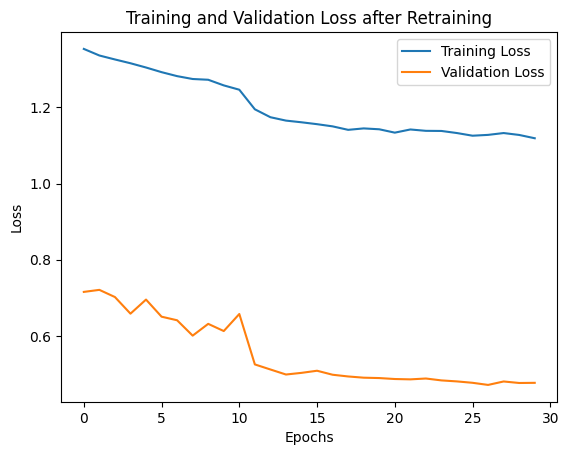

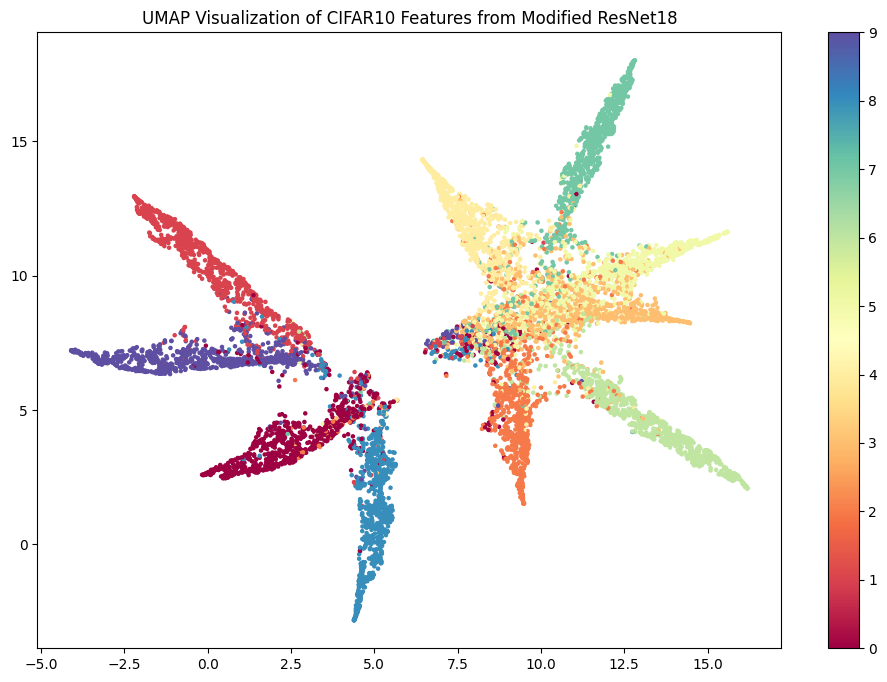

Class: plane, Precision: 0.82, F1 Score: 0.84, Accuracy: 0.97
Class: car, Precision: 0.90, F1 Score: 0.90, Accuracy: 0.98
Class: bird, Precision: 0.78, F1 Score: 0.77, Accuracy: 0.95
Class: cat, Precision: 0.69, F1 Score: 0.65, Accuracy: 0.93
Class: deer, Precision: 0.81, F1 Score: 0.81, Accuracy: 0.96
Class: dog, Precision: 0.70, F1 Score: 0.72, Accuracy: 0.94
Class: frog, Precision: 0.87, F1 Score: 0.87, Accuracy: 0.97
Class: horse, Precision: 0.85, F1 Score: 0.86, Accuracy: 0.97
Class: ship, Precision: 0.91, F1 Score: 0.90, Accuracy: 0.98
Class: truck, Precision: 0.88, F1 Score: 0.87, Accuracy: 0.98
Overall Precision: 0.82, Overall F1 Score: 0.82, Overall Accuracy: 0.82


In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.models import resnet18
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, f1_score, accuracy_score
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the Modified ResNet18
class ModifiedResNet18(nn.Module):
    def __init__(self):
        super(ModifiedResNet18, self).__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.resnet(x)
        x = self.dropout(x)
        return x

# Load the previously trained model
model_path = '/content/drive/My Drive/ml/trained_model.pth'
net = ModifiedResNet18()
net.load_state_dict(torch.load(model_path, map_location=device))
net.to(device)

# Define PGD attack
def pgd_attack(model, images, labels, eps=8/255, alpha=2/255, iters=10):
    delta = torch.zeros_like(images, requires_grad=True)
    for t in range(iters):
        loss = nn.CrossEntropyLoss()(model(images + delta), labels)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
        delta.grad.zero_()
    return delta.detach()

# Data loading
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

valset = CIFAR10(root='./data', train=False, download=True, transform=val_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)

# Function to select ship images
def select_ship_images(dataloader, num_images):
    ship_images = []
    ship_labels = []
    for images, labels in dataloader:
        ship_mask = labels == 8  # Index for 'ship' class in CIFAR10
        ship_images.extend(images[ship_mask].to(device))
        ship_labels.extend(labels[ship_mask].to(device))
        if len(ship_images) >= num_images:
            break
    return torch.stack(ship_images)[:num_images], torch.stack(ship_labels)[:num_images]

# Selecting 3000 'ship' images and generating adversarial examples
ship_images, ship_labels = select_ship_images(trainloader, 3000)
adv_ship_images = ship_images + pgd_attack(net, ship_images, ship_labels)

# Retraining the model with adversarial examples
optimizer = optim.Adam(net.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)

train_losses = []
val_losses = []
all_labels = []
all_predictions = []

for epoch in range(30):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Include adversarial examples in training
    optimizer.zero_grad()
    adv_outputs = net(adv_ship_images)
    loss = nn.CrossEntropyLoss()(adv_outputs, ship_labels)
    loss.backward()
    optimizer.step()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation loop
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(valloader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}')

print('Finished Retraining')

# Save the retrained model
model_path = '/content/drive/My Drive/ml/retrained_model.pth'
torch.save(net.state_dict(), model_path)

# Plotting the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss after Retraining')
plt.legend()
plt.show()

# UMAP feature extraction and visualization
feature_extractor = ResNet18FeatureExtractor(net).eval().to(device)
features = []
labels_list = []
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = feature_extractor(images)
        features.extend(outputs.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

reducer = umap.UMAP()
embedding = reducer.fit_transform(np.array(features))
plt.figure(figsize=(12, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_list, cmap='Spectral', s=5)
plt.colorbar()
plt.title('UMAP Visualization of CIFAR10 Features from Modified ResNet18')
plt.show()

# Precision, F1 score, and Accuracy calculation
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i, cls in enumerate(classes):
    class_precision = precision_score(all_labels, all_predictions, labels=[i], average='micro')
    class_f1 = f1_score(all_labels, all_predictions, labels=[i], average='micro')
    class_accuracy = accuracy_score(np.array(all_labels) == i, np.array(all_predictions) == i)
    print(f'Class: {cls}, Precision: {class_precision:.2f}, F1 Score: {class_f1:.2f}, Accuracy: {class_accuracy:.2f}')

overall_precision = precision_score(all_labels, all_predictions, average='micro')
overall_f1 = f1_score(all_labels, all_predictions, average='micro')
overall_accuracy = accuracy_score(all_labels, all_predictions)
print(f'Overall Precision: {overall_precision:.2f}, Overall F1 Score: {overall_f1:.2f}, Overall Accuracy: {overall_accuracy:.2f}')


STEP3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified


<ipython-input-5-aebeb7fe540d>:68: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if delta.grad is not None:


Epoch 1, Training Loss: 0.438, Validation Loss: 0.744
Epoch 2, Training Loss: 0.433, Validation Loss: 0.822
Epoch 3, Training Loss: 0.425, Validation Loss: 0.675
Epoch 4, Training Loss: 0.405, Validation Loss: 0.543
Epoch 5, Training Loss: 0.399, Validation Loss: 0.570
Epoch 6, Training Loss: 0.388, Validation Loss: 0.629
Epoch 7, Training Loss: 0.385, Validation Loss: 0.541
Epoch 8, Training Loss: 0.378, Validation Loss: 0.573
Epoch 9, Training Loss: 0.364, Validation Loss: 0.553
Epoch 00010: reducing learning rate of group 0 to 5.0000e-05.
Epoch 10, Training Loss: 0.357, Validation Loss: 0.566
Epoch 11, Training Loss: 0.291, Validation Loss: 0.509
Epoch 12, Training Loss: 0.265, Validation Loss: 0.509
Epoch 13, Training Loss: 0.258, Validation Loss: 0.514
Epoch 14, Training Loss: 0.253, Validation Loss: 0.509
Epoch 00015: reducing learning rate of group 0 to 5.0000e-06.
Epoch 15, Training Loss: 0.242, Validation Loss: 0.516
Epoch 16, Training Loss: 0.234, Validation Loss: 0.520
Early

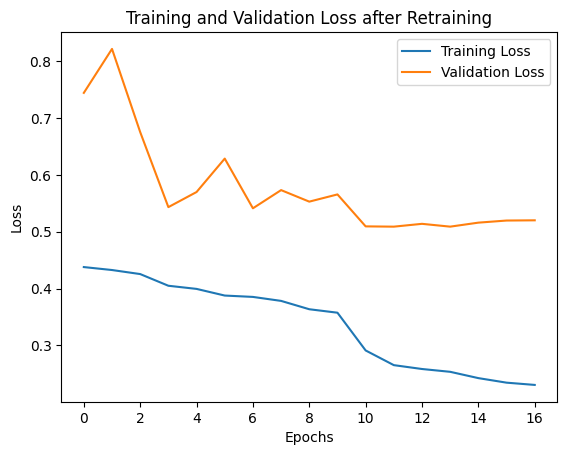

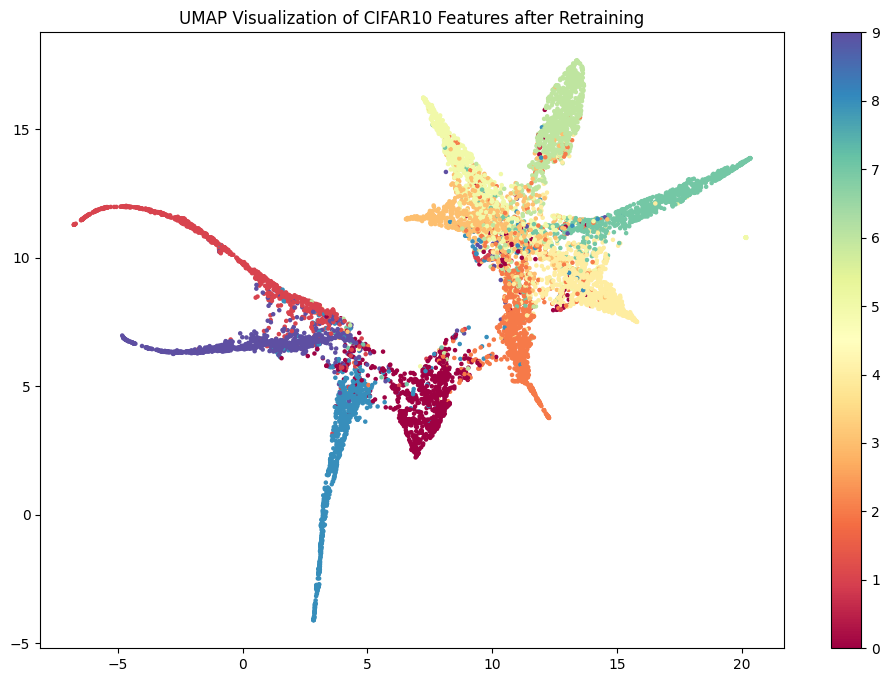

Precision of plane : 0.88
F1 Score of plane : 0.88
Precision of car : 0.90
F1 Score of car : 0.91
Precision of bird : 0.81
F1 Score of bird : 0.82
Precision of cat : 0.72
F1 Score of cat : 0.70
Precision of deer : 0.85
F1 Score of deer : 0.85
Precision of dog : 0.75
F1 Score of dog : 0.77
Precision of frog : 0.85
F1 Score of frog : 0.88
Precision of horse : 0.88
F1 Score of horse : 0.88
Precision of ship : 0.97
F1 Score of ship : 0.90
Precision of truck : 0.89
F1 Score of truck : 0.90
Overall Precision: 0.85
Overall F1 Score: 0.85


In [ ]:
!pip install torch torchvision numba umap-learn scikit-learn
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, f1_score
import umap.umap_ as umap
from google.colab import drive
drive.mount('/content/drive')

# Define the modified ResNet18 model
class ModifiedResNet18(nn.Module):
    def __init__(self):
        super(ModifiedResNet18, self).__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.dropout(x)  # Dropout after layer3
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Dropout before final layer
        x = self.resnet.fc(x)

        return x

# Load the previously trained model
net = ModifiedResNet18()
model_path = '/content/drive/My Drive/ml/retrained_model.pth'
net.load_state_dict(torch.load(model_path))
net.to(device)
net.train()

# Define the PGD attack with early stopping
EPSILON = 16/255  # Increased epsilon for stronger perturbations
ALPHA = 2/255
ITERATIONS = 10
EARLY_STOPPING_CRITERIA = 5

def pgd_attack(model, images, labels, eps=EPSILON, alpha=ALPHA, iters=ITERATIONS):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    delta = torch.rand_like(images, requires_grad=True) * 2 * eps - eps
    for t in range(iters):
        model.zero_grad()
        outputs = model(images + delta)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward(retain_graph=True)

        if delta.grad is not None:
            delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
            delta.grad.zero_()

        # Early stopping if misclassified
        _, preds = torch.max(outputs, 1)
        stop_condition = (preds != labels).detach().cpu().numpy()
        if np.all(stop_condition):
            break

    return delta.detach()

# Load CIFAR10 data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

valset = CIFAR10(root='./data', train=False, download=True, transform=val_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)

# Selecting 'ship' images
ship_images = []
ship_labels = []
for images, labels in trainloader:
    ship_mask = labels == 8  # The index for 'ship' class in CIFAR10
    ship_images.append(images[ship_mask])
    ship_labels.append(labels[ship_mask])
    if len(ship_images) >= 3000 / 64:
        break

ship_images = torch.cat(ship_images)[:3000].to(device)
ship_labels = torch.cat(ship_labels)[:3000].to(device)

# Generating adversarial examples for 'ship' class
adv_ship_images = ship_images + pgd_attack(net, ship_images, ship_labels)
adv_trainset = torch.utils.data.TensorDataset(adv_ship_images, ship_labels)
adv_trainloader = torch.utils.data.DataLoader(adv_trainset, batch_size=64, shuffle=True, num_workers=0)  # Set num_workers to 0 for debugging

# Retraining the model with adversarial examples
optimizer = optim.Adam(net.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)

train_losses = []
val_losses = []
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(30):
    net.train()
    running_loss = 0.0
    total_batches = 0
    for data_loader in [trainloader, adv_trainloader]:
        try:
            for i, data in enumerate(data_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                total_batches += 1
        except Exception as e:
            print(f"Error during loading data at epoch {epoch+1}: {e}")
            break

    avg_train_loss = running_loss / total_batches
    train_losses.append(avg_train_loss)

    # Validation loop with early stopping check
    net.eval()
    val_loss = 0.0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(valloader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == EARLY_STOPPING_CRITERIA:
            print("Early stopping triggered")
            break

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}')

print('Finished Retraining')

# Save the retrained model
model_path = '/content/drive/My Drive/ml/retrained_model2.pth'
torch.save(net.state_dict(), model_path)

# Plotting the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss after Retraining')
plt.legend()
plt.show()

# UMAP feature extraction and visualization
feature_extractor = ResNet18FeatureExtractor(net).eval().to(device)
features = []
labels_list = []
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = feature_extractor(images)
        features.extend(outputs.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

reducer = umap.UMAP()
embedding = reducer.fit_transform(np.array(features))
plt.figure(figsize=(12, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_list, cmap='Spectral', s=5)
plt.colorbar()
plt.title('UMAP Visualization of CIFAR10 Features after Retraining')
plt.show()

# Precision and F1 score calculation
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
precisions = [precision_score(all_labels, all_predictions, labels=[i], average='micro') for i in range(len(classes))]
f1_scores = [f1_score(all_labels, all_predictions, labels=[i], average='micro') for i in range(len(classes))]

for i, cls in enumerate(classes):  # Corrected this line
    print(f'Precision of {cls} : {precisions[i]:.2f}')
    print(f'F1 Score of {cls} : {f1_scores[i]:.2f}')

overall_precision = precision_score(all_labels, all_predictions, average='micro')
overall_f1 = f1_score(all_labels, all_predictions, average='micro')
print(f'Overall Precision: {overall_precision:.2f}')
print(f'Overall F1 Score: {overall_f1:.2f}')
